In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
N = 1000  # Some were run with 5000 oops, so we'll just use 1000 for consistency

In [3]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [4]:
MODELS = [os.path.join('analysis_beams_v7.0', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_beams_v7.0'))]

In [5]:
MODELS_DESCRIPTION = {k: k.replace('v7.0_', '') for k in MODELS}

In [6]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [7]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [8]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [9]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [10]:
remove_invalid = []

for model, model_results in results.items():
    pbar = tqdm(model_results.items(), desc=f'Loading {model} results')
    for test_set, test_set_results in pbar:
        pbar.set_postfix_str(test_set)
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)
            
            for k, v in test_set_results['data'].items():
                test_set_results['data'][k] = v[:N]

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_beams_v7.0/v7.0_16-beams results: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_64-beams results: 100%|██████████| 4/4 [00:32<00:00,  8.13s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_256-beams results: 100%|██████████| 4/4 [02:18<00:00, 34.66s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_512-beams results: 100%|██████████| 4/4 [04:42<00:00, 70.67s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_4-beams results: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, pool_15] 
Loading analysis_beams_v7.0/v7.0_128-beams results: 100%|██████████| 4/4 [01:09<00:00, 17.28s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_8-beams results: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_32-beams results: 100%|██████████| 4/4 [00:17<00:00,  4.44s/it, pool_15] 
Loading analysis_beams_v7.0/v7.0_2-beams results: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s, pool_15] 


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 6993.42it/s]


In [12]:
# Replace 'beam_val_' with 'val_beam' in columns where 'beam_val_' is present
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        columns_before = set(data.keys())
        changed_columns = []
        for k in columns_before:
            if 'beam_val_' in k:
                data[k.replace('beam_val_', 'val_beam_')] = data[k]
                changed_columns.append(k)

        for k in changed_columns:
            del data[k]

100%|██████████| 4/4 [00:00<00:00, 28484.24it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 1205.35it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 41.29it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        for maybe_val in ['', '_val']:
            test_set_results['data'][f'is_finite{maybe_val}'] = np.array([np.isfinite(r2) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'FVU-eps_accuracy{maybe_val}'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu{maybe_val}'] = np.array([1 - r2 for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])
            test_set_results['data'][f'log_fvu{maybe_val}'] = np.array([np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data'][f'r2{maybe_val}_best_beam']])

            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'] = np.copy(test_set_results['data'][f'fvu{maybe_val}'])
            test_set_results['data'][f'fvu_not_epsilon{maybe_val}'][test_set_results['data'][f'FVU-eps_accuracy{maybe_val}']] = np.nan

            test_set_results['data'][f'log_fvu_not_epsilon{maybe_val}'] = np.array([np.log10(fvu) for fvu in test_set_results['data'][f'fvu_not_epsilon{maybe_val}']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [16]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'x_val', 'y_val', 'y_noisy_val', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'FVU-eps_accuracy_val',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_close_val_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'NSRTS_accuracy_r2_val_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'fvu_not_epsilon_val',
 'fvu_val',
 'is_finite',
 'is_finite_val',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_fvu_not_epsilon_val',
 'log_fvu_val',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'mse_val_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'r2_val_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_rec

In [17]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [18]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'NSRTS_accuracy_close_val_best_beam': 0,
    'NSRTS_accuracy_r2_val_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'mse_val_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'r2_val_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [19]:
from functools import partial

In [20]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [21]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_beams_v7.0/v7.0_16-beams feynman:  83%|████████▎ | 40/48 [00:04<00:00,  8.97it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_1-beams soose_nc:  33%|███▎      | 16/48 [00:01<00:03,  9.39it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams_v7.0/v7.0_2-beams pool_15: 100%|██████████| 48/48 [00:05<00:00,  8.62it/s]


In [22]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [23]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_64-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_256-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)"
analysis_beams_v7.0/v7.0_512-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_4-beams,"0.999 (0.997, 1.0)","0.999 (0.997, 1.0)","0.995 (0.99, 0.999)","0.997 (0.993, 1.0)"
analysis_beams_v7.0/v7.0_128-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_1-beams,"0.994 (0.989, 0.998)","0.982 (0.974, 0.99)","0.982 (0.974, 0.99)","0.982 (0.973, 0.989)"
analysis_beams_v7.0/v7.0_8-beams,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.998 (0.995, 1.0)","0.996 (0.992, 0.999)"
analysis_beams_v7.0/v7.0_32-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams_v7.0/v7.0_2-beams,"0.995 (0.99, 0.999)","0.99 (0.984, 0.996)","0.993 (0.987, 0.997)","0.98 (0.971, 0.988)"


#### Recovery Rate

In [24]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.842 (0.819, 0.864)","0.789 (0.765, 0.815)","0.83 (0.806, 0.854)","0.599 (0.57, 0.628)"
analysis_beams_v7.0/v7.0_64-beams,"0.913 (0.894, 0.931)","0.838 (0.817, 0.859)","0.932 (0.917, 0.947)","0.637 (0.605, 0.666)"
analysis_beams_v7.0/v7.0_256-beams,"0.956 (0.943, 0.969)","0.891 (0.87, 0.909)","0.979 (0.969, 0.987)","0.684 (0.653, 0.71)"
analysis_beams_v7.0/v7.0_512-beams,"0.96 (0.946, 0.971)","0.901 (0.882, 0.919)","0.983 (0.974, 0.99)","0.735 (0.708, 0.762)"
analysis_beams_v7.0/v7.0_4-beams,"0.758 (0.73, 0.784)","0.677 (0.649, 0.707)","0.698 (0.67, 0.726)","0.53 (0.498, 0.561)"
analysis_beams_v7.0/v7.0_128-beams,"0.939 (0.925, 0.954)","0.893 (0.872, 0.913)","0.963 (0.95, 0.973)","0.658 (0.63, 0.686)"
analysis_beams_v7.0/v7.0_1-beams,"0.674 (0.646, 0.701)","0.496 (0.464, 0.526)","0.531 (0.5, 0.563)","0.429 (0.398, 0.459)"
analysis_beams_v7.0/v7.0_8-beams,"0.8 (0.775, 0.824)","0.732 (0.704, 0.759)","0.785 (0.758, 0.812)","0.595 (0.565, 0.626)"
analysis_beams_v7.0/v7.0_32-beams,"0.877 (0.857, 0.896)","0.822 (0.799, 0.846)","0.852 (0.827, 0.874)","0.637 (0.608, 0.668)"
analysis_beams_v7.0/v7.0_2-beams,"0.718 (0.691, 0.747)","0.56 (0.527, 0.59)","0.615 (0.588, 0.644)","0.496 (0.465, 0.527)"


In [25]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.913 (0.896, 0.929)","0.866 (0.844, 0.887)","0.973 (0.963, 0.982)","0.747 (0.72, 0.775)"
analysis_beams_v7.0/v7.0_64-beams,"0.957 (0.944, 0.97)","0.903 (0.885, 0.92)","0.989 (0.982, 0.995)","0.851 (0.829, 0.873)"
analysis_beams_v7.0/v7.0_256-beams,"0.992 (0.987, 0.997)","0.925 (0.907, 0.94)","0.999 (0.997, 1.0)","0.858 (0.837, 0.878)"
analysis_beams_v7.0/v7.0_512-beams,"0.985 (0.977, 0.992)","0.934 (0.918, 0.948)","0.999 (0.997, 1.0)","0.905 (0.886, 0.922)"
analysis_beams_v7.0/v7.0_4-beams,"0.859 (0.837, 0.879)","0.771 (0.745, 0.796)","0.922 (0.904, 0.937)","0.693 (0.664, 0.723)"
analysis_beams_v7.0/v7.0_128-beams,"0.977 (0.967, 0.986)","0.926 (0.91, 0.943)","0.994 (0.989, 0.998)","0.85 (0.827, 0.871)"
analysis_beams_v7.0/v7.0_1-beams,"0.768 (0.742, 0.793)","0.6 (0.568, 0.63)","0.758 (0.729, 0.784)","0.535 (0.503, 0.568)"
analysis_beams_v7.0/v7.0_8-beams,"0.887 (0.866, 0.905)","0.821 (0.796, 0.842)","0.964 (0.952, 0.975)","0.759 (0.734, 0.785)"
analysis_beams_v7.0/v7.0_32-beams,"0.935 (0.919, 0.95)","0.873 (0.853, 0.894)","0.986 (0.978, 0.993)","0.82 (0.794, 0.843)"
analysis_beams_v7.0/v7.0_2-beams,"0.8 (0.775, 0.826)","0.662 (0.633, 0.689)","0.833 (0.809, 0.855)","0.639 (0.609, 0.669)"


In [26]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.725 (0.697, 0.754)","0.681 (0.652, 0.709)","0.664 (0.634, 0.692)","0.319 (0.292, 0.349)"
analysis_beams_v7.0/v7.0_64-beams,"0.809 (0.784, 0.833)","0.758 (0.732, 0.784)","0.845 (0.82, 0.867)","0.366 (0.338, 0.395)"
analysis_beams_v7.0/v7.0_256-beams,"0.851 (0.828, 0.873)","0.822 (0.798, 0.845)","0.942 (0.929, 0.956)","0.402 (0.371, 0.431)"
analysis_beams_v7.0/v7.0_512-beams,"0.869 (0.847, 0.89)","0.85 (0.828, 0.872)","0.948 (0.932, 0.959)","0.469 (0.438, 0.502)"
analysis_beams_v7.0/v7.0_4-beams,"0.647 (0.618, 0.678)","0.534 (0.504, 0.564)","0.519 (0.488, 0.554)","0.276 (0.25, 0.306)"
analysis_beams_v7.0/v7.0_128-beams,"0.84 (0.818, 0.863)","0.831 (0.808, 0.852)","0.893 (0.874, 0.912)","0.383 (0.353, 0.411)"
analysis_beams_v7.0/v7.0_1-beams,"0.572 (0.541, 0.601)","0.37 (0.342, 0.401)","0.402 (0.372, 0.432)","0.198 (0.173, 0.223)"
analysis_beams_v7.0/v7.0_8-beams,"0.695 (0.666, 0.723)","0.604 (0.574, 0.632)","0.58 (0.547, 0.611)","0.294 (0.266, 0.322)"
analysis_beams_v7.0/v7.0_32-beams,"0.757 (0.73, 0.781)","0.721 (0.692, 0.748)","0.741 (0.714, 0.769)","0.367 (0.339, 0.398)"
analysis_beams_v7.0/v7.0_2-beams,"0.603 (0.569, 0.633)","0.447 (0.416, 0.477)","0.451 (0.421, 0.482)","0.268 (0.24, 0.296)"


In [27]:
m = 'FVU-eps_accuracy_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.725 (0.697, 0.751)","0.679 (0.648, 0.708)","0.665 (0.637, 0.695)","0.315 (0.287, 0.344)"
analysis_beams_v7.0/v7.0_64-beams,"0.807 (0.782, 0.83)","0.759 (0.732, 0.785)","0.841 (0.819, 0.862)","0.363 (0.334, 0.393)"
analysis_beams_v7.0/v7.0_256-beams,"0.848 (0.824, 0.869)","0.817 (0.792, 0.841)","0.94 (0.925, 0.955)","0.4 (0.371, 0.43)"
analysis_beams_v7.0/v7.0_512-beams,"0.866 (0.844, 0.888)","0.851 (0.83, 0.872)","0.947 (0.932, 0.96)","0.463 (0.432, 0.494)"
analysis_beams_v7.0/v7.0_4-beams,"0.647 (0.619, 0.676)","0.534 (0.503, 0.565)","0.52 (0.49, 0.552)","0.277 (0.249, 0.306)"
analysis_beams_v7.0/v7.0_128-beams,"0.836 (0.813, 0.859)","0.827 (0.803, 0.849)","0.888 (0.869, 0.908)","0.379 (0.351, 0.408)"
analysis_beams_v7.0/v7.0_1-beams,"0.569 (0.538, 0.599)","0.371 (0.342, 0.4)","0.402 (0.37, 0.433)","0.201 (0.177, 0.225)"
analysis_beams_v7.0/v7.0_8-beams,"0.694 (0.666, 0.723)","0.604 (0.573, 0.633)","0.579 (0.548, 0.608)","0.287 (0.259, 0.316)"
analysis_beams_v7.0/v7.0_32-beams,"0.756 (0.726, 0.782)","0.719 (0.688, 0.747)","0.743 (0.716, 0.769)","0.361 (0.332, 0.389)"
analysis_beams_v7.0/v7.0_2-beams,"0.601 (0.571, 0.631)","0.446 (0.414, 0.476)","0.452 (0.424, 0.483)","0.27 (0.241, 0.297)"


#### Numeric Error

In [28]:
m = 'fvu_not_epsilon'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.218 (0.17, 0.269)","0.344 (0.292, 0.405)","0.019 (0.011, 0.028)","0.655 (0.231, 1.495)"
analysis_beams_v7.0/v7.0_64-beams,"0.15 (0.107, 0.202)","0.324 (0.264, 0.386)","0.012 (0.006, 0.021)","0.144 (0.119, 0.169)"
analysis_beams_v7.0/v7.0_256-beams,"0.038 (0.014, 0.074)","0.323 (0.257, 0.39)","0.003 (0.001, 0.005)","0.127 (0.106, 0.15)"
analysis_beams_v7.0/v7.0_512-beams,"0.043 (0.019, 0.075)","0.353 (0.283, 0.427)","0.005 (0.001, 0.013)","0.082 (0.062, 0.104)"
analysis_beams_v7.0/v7.0_4-beams,"1.437 (0.272, 3.903)","0.559 (0.466, 0.662)","0.111 (0.078, 0.144)","46673726044592.69 (0.489, 144197142193073.47)"
analysis_beams_v7.0/v7.0_128-beams,"0.095 (0.055, 0.144)","0.342 (0.273, 0.407)","0.013 (0.004, 0.023)","0.134 (0.112, 0.158)"
analysis_beams_v7.0/v7.0_1-beams,"8.509 (2.159, 17.878)","4.92 (1.923, 11.342)","3.359 (0.699, 8.758)","28694830982.073 (32.871, 87467852867.977)"
analysis_beams_v7.0/v7.0_8-beams,"0.314 (0.263, 0.37)","0.425 (0.365, 0.485)","0.029 (0.017, 0.043)","2.0151218241236655e+25 (0.387, 7.9600055417666..."
analysis_beams_v7.0/v7.0_32-beams,"0.185 (0.142, 0.238)","0.366 (0.306, 0.431)","0.012 (0.007, 0.02)","0.188 (0.158, 0.221)"
analysis_beams_v7.0/v7.0_2-beams,"27.822 (1.499, 70.86)","3.019 (1.675, 5.014)","0.743 (0.314, 1.637)","106659.224 (31.615, 327049.44)"


In [29]:
m = 'fvu_not_epsilon_val'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"3.69 (0.872, 7.795)","0.952 (0.47, 1.747)","0.019 (0.011, 0.029)","538715830594.236 (16.283, 1681892242453.105)"
analysis_beams_v7.0/v7.0_64-beams,"15.748 (0.259, 52.321)","76.933 (0.786, 245.37)","0.012 (0.006, 0.022)","1019409.481 (2.739, 3166963.13)"
analysis_beams_v7.0/v7.0_256-beams,"1.481 (0.066, 4.757)","399.258 (0.53, 1320.32)","0.003 (0.001, 0.005)","4.2409718465885086e+170 (0.577, 1.325631412653..."
analysis_beams_v7.0/v7.0_512-beams,"9.751 (0.089, 33.476)","0.492 (0.366, 0.684)","0.005 (0.001, 0.013)","567965503.429 (0.529, 1545594221.171)"
analysis_beams_v7.0/v7.0_4-beams,"6.073 (1.115, 16.382)","4.283 (0.832, 11.299)","0.113 (0.083, 0.151)","105123347151443.06 (1199.486, 324182203802683.0)"
analysis_beams_v7.0/v7.0_128-beams,"985.171 (0.488, 2725.86)","0.582 (0.421, 0.811)","0.013 (0.004, 0.026)","6910.472 (1.475, 21196.769)"
analysis_beams_v7.0/v7.0_1-beams,"72.433 (4.14, 221.517)","12.832 (2.992, 32.608)","3.37 (0.685, 8.588)","388127984724.879 (9086.277, 1185512420316.345)"
analysis_beams_v7.0/v7.0_8-beams,"33.271 (0.888, 103.01)","70659216769.109 (0.93, 224703635933.748)","0.03 (0.019, 0.044)","6.203828259806867e+30 (4.948, 1.92595395685832..."
analysis_beams_v7.0/v7.0_32-beams,"117416.03 (2.545, 389946.083)","293.522 (1.316, 920.511)","0.013 (0.007, 0.021)","478303530.584 (1.837, 1520405016.681)"
analysis_beams_v7.0/v7.0_2-beams,"1.53360698865648e+108 (201.717, 4.962099959264...","47.223 (6.555, 130.375)","0.771 (0.322, 1.799)","9.299725238127517e+66 (16441.336, 2.8376416829..."


#### Time

In [30]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.954 (0.942, 0.964)","0.966 (0.957, 0.98)","0.981 (0.973, 0.988)","1.008 (0.999, 1.024)"
analysis_beams_v7.0/v7.0_64-beams,"3.626 (3.604, 3.66)","3.524 (3.5, 3.551)","3.673 (3.644, 3.699)","3.897 (3.833, 3.958)"
analysis_beams_v7.0/v7.0_256-beams,"15.546 (15.373, 15.703)","15.941 (15.74, 16.134)","19.375 (18.889, 19.76)","20.031 (19.624, 20.517)"
analysis_beams_v7.0/v7.0_512-beams,"38.625 (37.852, 39.391)","36.377 (35.694, 37.112)","40.823 (39.651, 42.689)","43.219 (41.538, nan)"
analysis_beams_v7.0/v7.0_4-beams,"0.36 (0.356, 0.367)","0.353 (0.35, 0.356)","0.359 (0.355, 0.362)","0.355 (0.351, 0.359)"
analysis_beams_v7.0/v7.0_128-beams,"7.584 (7.522, 7.664)","7.444 (7.384, 7.51)","7.571 (7.49, 7.637)","8.057 (7.938, 8.167)"
analysis_beams_v7.0/v7.0_1-beams,"0.069 (0.068, 0.07)","0.073 (0.071, 0.074)","0.057 (0.056, 0.058)","0.1 (0.097, 0.103)"
analysis_beams_v7.0/v7.0_8-beams,"0.538 (0.534, 0.541)","0.532 (0.529, 0.535)","0.544 (0.541, 0.548)","0.567 (0.561, 0.571)"
analysis_beams_v7.0/v7.0_32-beams,"1.842 (1.823, 1.858)","1.844 (1.826, 1.858)","1.857 (1.832, 1.875)","1.953 (1.927, 1.976)"
analysis_beams_v7.0/v7.0_2-beams,"0.195 (0.18, 0.251)","0.146 (0.135, 0.154)","0.265 (0.262, 0.266)","0.183 (0.175, 0.194)"


In [31]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.954 (0.942, 0.964)","0.966 (0.957, 0.982)","0.981 (0.973, 0.988)","1.007 (0.999, 1.024)"
analysis_beams_v7.0/v7.0_64-beams,"3.626 (3.602, 3.66)","3.524 (3.5, 3.551)","3.673 (3.644, 3.697)","3.892 (3.831, 3.957)"
analysis_beams_v7.0/v7.0_256-beams,"15.549 (15.372, 15.702)","15.934 (15.754, 16.144)","19.381 (18.976, 19.722)","20.026 (19.55, 20.516)"
analysis_beams_v7.0/v7.0_512-beams,"38.625 (37.806, 39.452)","36.389 (35.687, 37.084)","40.842 (39.762, 42.925)","43.219 (41.454, 55.284)"
analysis_beams_v7.0/v7.0_4-beams,"0.36 (0.355, 0.367)","0.353 (0.35, 0.356)","0.359 (0.355, 0.362)","0.355 (0.352, 0.359)"
analysis_beams_v7.0/v7.0_128-beams,"7.584 (7.521, 7.661)","7.441 (7.388, 7.509)","7.57 (7.496, 7.637)","8.054 (7.919, 8.167)"
analysis_beams_v7.0/v7.0_1-beams,"0.069 (0.068, 0.07)","0.073 (0.071, 0.074)","0.057 (0.056, 0.058)","0.099 (0.097, 0.102)"
analysis_beams_v7.0/v7.0_8-beams,"0.537 (0.535, 0.542)","0.532 (0.528, 0.535)","0.544 (0.541, 0.548)","0.568 (0.561, 0.571)"
analysis_beams_v7.0/v7.0_32-beams,"1.843 (1.826, 1.858)","1.844 (1.826, 1.858)","1.857 (1.832, 1.874)","1.955 (1.936, 1.975)"
analysis_beams_v7.0/v7.0_2-beams,"0.194 (0.18, 0.251)","0.146 (0.136, 0.156)","0.265 (0.263, 0.266)","0.183 (0.175, 0.194)"


#### Text Metrics

In [32]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"2.296 (2.143, 2.53)","1.945 (1.824, 2.048)","4.806 (3.994, 5.587)","15.906 (13.618, 18.307)"
analysis_beams_v7.0/v7.0_64-beams,"2.314 (2.135, 2.549)","1.995 (1.872, 2.12)","5.177 (4.492, 5.742)","16.719 (14.396, 20.23)"
analysis_beams_v7.0/v7.0_256-beams,"2.307 (2.123, 2.526)","1.994 (1.865, 2.147)","4.929 (4.311, 5.414)","18.151 (16.079, 22.27)"
analysis_beams_v7.0/v7.0_512-beams,"2.33 (2.155, 2.595)","1.917 (1.816, 2.045)","4.912 (4.431, 5.681)","14.469 (12.169, 17.407)"
analysis_beams_v7.0/v7.0_4-beams,"2.117 (2.017, 2.413)","2.01 (1.882, 2.145)","5.734 (4.768, 6.765)","15.083 (12.624, 18.132)"
analysis_beams_v7.0/v7.0_128-beams,"2.168 (1.977, 2.395)","1.963 (1.812, 2.096)","5.391 (4.786, 6.197)","16.47 (14.071, 19.841)"
analysis_beams_v7.0/v7.0_1-beams,"2.122 (2.003, 2.292)","1.919 (1.842, 2.026)","5.6 (4.584, 6.528)","16.438 (13.693, 19.91)"
analysis_beams_v7.0/v7.0_8-beams,"2.398 (2.201, 2.587)","2.042 (1.925, 2.17)","5.167 (4.508, 5.969)","19.556 (16.117, 23.634)"
analysis_beams_v7.0/v7.0_32-beams,"2.454 (2.211, 2.734)","1.975 (1.852, 2.084)","5.315 (4.618, 6.359)","16.787 (14.11, 20.574)"
analysis_beams_v7.0/v7.0_2-beams,"2.343 (2.144, 2.596)","2.005 (1.88, 2.183)","4.462 (3.778, 5.123)","15.391 (12.014, 18.432)"


In [33]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"11.05 (10.509, 11.635)","7.784 (7.257, 8.24)","11.625 (10.964, 12.318)","21.856 (21.127, 22.595)"
analysis_beams_v7.0/v7.0_64-beams,"11.151 (10.59, 11.726)","7.05 (6.519, 7.614)","12.282 (11.582, 13.009)","22.313 (21.569, 23.094)"
analysis_beams_v7.0/v7.0_256-beams,"12.056 (11.437, 12.63)","7.171 (6.669, 7.686)","11.549 (10.919, 12.245)","22.772 (21.958, 23.645)"
analysis_beams_v7.0/v7.0_512-beams,"11.74 (11.184, 12.323)","6.741 (6.231, 7.283)","11.426 (10.694, 12.147)","22.017 (21.235, 22.753)"
analysis_beams_v7.0/v7.0_4-beams,"10.411 (9.795, 11.046)","7.992 (7.508, 8.478)","12.881 (12.167, 13.583)","21.397 (20.713, 22.132)"
analysis_beams_v7.0/v7.0_128-beams,"10.966 (10.382, 11.544)","6.76 (6.267, 7.257)","11.728 (11.04, 12.464)","22.156 (21.438, 22.948)"
analysis_beams_v7.0/v7.0_1-beams,"9.658 (9.059, 10.22)","7.812 (7.354, 8.309)","13.073 (12.459, 13.664)","22.429 (21.729, 23.125)"
analysis_beams_v7.0/v7.0_8-beams,"10.398 (9.808, 10.955)","7.888 (7.376, 8.388)","12.673 (11.935, 13.42)","22.253 (21.543, 22.96)"
analysis_beams_v7.0/v7.0_32-beams,"10.978 (10.379, 11.58)","7.27 (6.776, 7.8)","13.228 (12.531, 13.971)","22.258 (21.506, 23.006)"
analysis_beams_v7.0/v7.0_2-beams,"10.292 (9.706, 10.9)","8.067 (7.615, 8.553)","12.414 (11.725, 13.027)","21.41 (20.645, 22.197)"


In [34]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.92 (0.914, 0.925)","0.907 (0.899, 0.916)","0.843 (0.833, 0.851)","0.851 (0.844, 0.858)"
analysis_beams_v7.0/v7.0_64-beams,"0.919 (0.914, 0.924)","0.919 (0.911, 0.927)","0.84 (0.831, 0.85)","0.857 (0.85, 0.864)"
analysis_beams_v7.0/v7.0_256-beams,"0.916 (0.911, 0.92)","0.927 (0.92, 0.935)","0.857 (0.848, 0.866)","0.861 (0.855, 0.868)"
analysis_beams_v7.0/v7.0_512-beams,"0.914 (0.909, 0.919)","0.931 (0.924, 0.939)","0.859 (0.85, 0.869)","0.864 (0.857, 0.87)"
analysis_beams_v7.0/v7.0_4-beams,"0.908 (0.902, 0.914)","0.89 (0.883, 0.899)","0.819 (0.809, 0.829)","0.846 (0.838, 0.852)"
analysis_beams_v7.0/v7.0_128-beams,"0.922 (0.917, 0.928)","0.928 (0.921, 0.935)","0.849 (0.84, 0.858)","0.862 (0.856, 0.868)"
analysis_beams_v7.0/v7.0_1-beams,"0.907 (0.899, 0.914)","0.868 (0.857, 0.878)","0.794 (0.782, 0.804)","0.821 (0.811, 0.83)"
analysis_beams_v7.0/v7.0_8-beams,"0.917 (0.911, 0.922)","0.896 (0.888, 0.905)","0.832 (0.822, 0.841)","0.847 (0.84, 0.855)"
analysis_beams_v7.0/v7.0_32-beams,"0.918 (0.912, 0.924)","0.913 (0.906, 0.922)","0.826 (0.816, 0.835)","0.861 (0.855, 0.868)"
analysis_beams_v7.0/v7.0_2-beams,"0.901 (0.894, 0.908)","0.875 (0.865, 0.884)","0.82 (0.81, 0.828)","0.824 (0.814, 0.834)"


In [35]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"0.743 (0.727, 0.758)","0.777 (0.763, 0.794)","0.631 (0.611, 0.651)","0.517 (0.503, 0.533)"
analysis_beams_v7.0/v7.0_64-beams,"0.732 (0.717, 0.747)","0.812 (0.795, 0.828)","0.646 (0.628, 0.665)","0.533 (0.519, 0.548)"
analysis_beams_v7.0/v7.0_256-beams,"0.723 (0.708, 0.737)","0.824 (0.809, 0.838)","0.679 (0.661, 0.697)","0.54 (0.525, 0.555)"
analysis_beams_v7.0/v7.0_512-beams,"0.734 (0.72, 0.748)","0.835 (0.82, 0.848)","0.7 (0.681, 0.718)","0.552 (0.537, 0.567)"
analysis_beams_v7.0/v7.0_4-beams,"0.733 (0.718, 0.749)","0.735 (0.719, 0.751)","0.569 (0.549, 0.59)","0.509 (0.494, 0.523)"
analysis_beams_v7.0/v7.0_128-beams,"0.746 (0.731, 0.76)","0.829 (0.814, 0.844)","0.659 (0.64, 0.677)","0.538 (0.523, 0.553)"
analysis_beams_v7.0/v7.0_1-beams,"0.709 (0.694, 0.724)","0.698 (0.682, 0.714)","0.518 (0.5, 0.535)","0.469 (0.456, 0.483)"
analysis_beams_v7.0/v7.0_8-beams,"0.749 (0.734, 0.763)","0.753 (0.738, 0.769)","0.6 (0.583, 0.622)","0.499 (0.484, 0.513)"
analysis_beams_v7.0/v7.0_32-beams,"0.739 (0.725, 0.755)","0.798 (0.781, 0.814)","0.614 (0.594, 0.634)","0.525 (0.511, 0.54)"
analysis_beams_v7.0/v7.0_2-beams,"0.715 (0.7, 0.729)","0.715 (0.7, 0.732)","0.554 (0.536, 0.571)","0.491 (0.476, 0.506)"


In [36]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams_v7.0/v7.0_16-beams,"4.068 (3.856, 4.278)","2.885 (2.706, 3.083)","3.961 (3.707, 4.213)","8.732 (8.442, 9.019)"
analysis_beams_v7.0/v7.0_64-beams,"4.247 (4.054, 4.462)","2.652 (2.452, 2.831)","4.164 (3.944, 4.416)","8.89 (8.588, 9.17)"
analysis_beams_v7.0/v7.0_256-beams,"4.688 (4.463, 4.904)","2.702 (2.504, 2.909)","3.883 (3.655, 4.134)","9.037 (8.725, 9.345)"
analysis_beams_v7.0/v7.0_512-beams,"4.596 (4.382, 4.809)","2.604 (2.405, 2.806)","3.802 (3.577, 4.049)","8.674 (8.356, 8.98)"
analysis_beams_v7.0/v7.0_4-beams,"3.903 (3.68, 4.112)","3.089 (2.911, 3.27)","4.377 (4.112, 4.627)","8.697 (8.423, 9.022)"
analysis_beams_v7.0/v7.0_128-beams,"4.115 (3.921, 4.338)","2.547 (2.342, 2.743)","3.963 (3.717, 4.21)","8.929 (8.608, 9.22)"
analysis_beams_v7.0/v7.0_1-beams,"3.704 (3.505, 3.911)","3.193 (3.019, 3.369)","4.608 (4.381, 4.841)","9.009 (8.711, 9.326)"
analysis_beams_v7.0/v7.0_8-beams,"3.875 (3.68, 4.066)","3.005 (2.825, 3.193)","4.277 (4.032, 4.544)","9.044 (8.722, 9.343)"
analysis_beams_v7.0/v7.0_32-beams,"4.134 (3.913, 4.337)","2.729 (2.534, 2.908)","4.332 (4.08, 4.575)","8.896 (8.601, 9.196)"
analysis_beams_v7.0/v7.0_2-beams,"3.827 (3.635, 4.04)","3.147 (2.972, 3.312)","4.299 (4.094, 4.534)","8.642 (8.344, 8.959)"


In [37]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [72.5\ (69.7, 75.4) <table_CI>], [68.1\ (65.2, 70.9) <table_CI>], [66.4\ (63.4, 69.2) <table_CI>], [31.9\ (29.2, 34.9) <table_CI>],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [80.9\ (78.4, 83.3) <table_CI>], [75.8\ (73.2, 78.4) <table_CI>], [84.5\ (82.0, 86.7) <table_CI>], [36.6\ (33.8, 39.5) <table_CI>],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*85.1\ (82.8, 87.3) <table_CI>

In [39]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [91.3\ (89.6, 92.9) <table_CI>], [86.6\ (84.4, 88.7) <table_CI>], [97.3\ (96.3, 98.2) <table_CI>], [74.7\ (72.0, 77.5) <table_CI>],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [95.7\ (94.4, 97.0) <table_CI>], [*90.3\ (88.5, 92.0) <table_CI>*], [98.9\ (98.2, 99.5) <table_CI>], [85.1\ (82.9, 87.3) <table_CI>],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*99.2\ (98.7, 99.7) <table_C

In [40]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams_v7.0/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.07\ (3.86, 4.28) <table_CI>*], [*2.88\ (2.71, 3.08) <table_CI>*], [*3.96\ (3.71, 4.21) <table_CI>*], [*8.73\ (8.44, 9.02) <table_CI>*],
  [analysis_beams_v7.0/64-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [4.25\ (4.05, 4.46) <table_CI>], [*2.65\ (2.45, 2.83) <table_CI>*], [*4.16\ (3.94, 4.42) <table_CI>*], [*8.89\ (8.59, 9.17) <table_CI>*],
  [analysis_beams_v7.0/256-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [4.69\ (4.46, 4.9

# Aggregated

In [41]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [42]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_beams_v7.0/v7.0_16-beams:  83%|████████▎ | 40/48 [00:12<00:02,  3.98it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_256-beams:  83%|████████▎ | 40/48 [00:10<00:01,  4.21it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams_v7.0/v7.0_2-beams: 100%|██████████| 48/48 [00:13<00:00,  3.52it/s]


In [43]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [44]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_beams_v7.0/v7.0_16-beams,analysis_beams_v7.0/v7.0_64-beams,analysis_beams_v7.0/v7.0_256-beams,analysis_beams_v7.0/v7.0_512-beams,analysis_beams_v7.0/v7.0_4-beams,analysis_beams_v7.0/v7.0_128-beams,analysis_beams_v7.0/v7.0_1-beams,analysis_beams_v7.0/v7.0_8-beams,analysis_beams_v7.0/v7.0_32-beams,analysis_beams_v7.0/v7.0_2-beams
FVU-eps_accuracy,"0.597 (0.581, 0.612)","0.694 (0.681, 0.71)","0.754 (0.74, 0.767)","0.784 (0.771, 0.796)","0.494 (0.478, 0.51)","0.736 (0.722, 0.75)","0.386 (0.37, 0.401)","0.543 (0.527, 0.558)","0.647 (0.633, 0.661)","0.442 (0.427, 0.457)"
FVU-eps_accuracy_val,"0.596 (0.58, 0.61)","0.693 (0.678, 0.707)","0.751 (0.738, 0.764)","0.782 (0.768, 0.794)","0.495 (0.479, 0.509)","0.732 (0.719, 0.746)","0.386 (0.37, 0.401)","0.541 (0.524, 0.556)","0.644 (0.629, 0.658)","0.442 (0.427, 0.457)"
NSRTS_accuracy_close_best_beam,"0.765 (0.751, 0.778)","0.83 (0.819, 0.842)","0.877 (0.867, 0.888)","0.895 (0.885, 0.904)","0.665 (0.65, 0.68)","0.863 (0.852, 0.873)","0.533 (0.518, 0.548)","0.728 (0.715, 0.741)","0.797 (0.784, 0.81)","0.597 (0.582, 0.612)"
NSRTS_accuracy_close_val_best_beam,"0.764 (0.75, 0.776)","0.83 (0.819, 0.841)","0.876 (0.866, 0.886)","0.894 (0.884, 0.904)","0.665 (0.651, 0.68)","0.863 (0.851, 0.873)","0.533 (0.518, 0.548)","0.729 (0.716, 0.742)","0.796 (0.784, 0.809)","0.598 (0.582, 0.612)"
NSRTS_accuracy_r2_best_beam,"0.875 (0.865, 0.884)","0.925 (0.916, 0.934)","0.944 (0.936, 0.95)","0.956 (0.949, 0.962)","0.811 (0.799, 0.823)","0.937 (0.929, 0.944)","0.666 (0.65, 0.68)","0.857 (0.846, 0.867)","0.903 (0.894, 0.912)","0.733 (0.72, 0.745)"
NSRTS_accuracy_r2_val_best_beam,"0.868 (0.858, 0.878)","0.914 (0.906, 0.923)","0.934 (0.927, 0.942)","0.948 (0.941, 0.955)","0.809 (0.796, 0.822)","0.926 (0.918, 0.934)","0.661 (0.647, 0.676)","0.849 (0.839, 0.86)","0.894 (0.885, 0.903)","0.728 (0.714, 0.742)"
accuracy_best_beam,"0.254 (0.242, 0.268)","0.264 (0.251, 0.278)","0.275 (0.262, 0.29)","0.3 (0.285, 0.314)","0.232 (0.22, 0.246)","0.291 (0.278, 0.306)","0.177 (0.166, 0.189)","0.236 (0.223, 0.25)","0.268 (0.255, 0.281)","0.19 (0.178, 0.202)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","0.998 (0.996, 0.999)","1.0 (1.0, 1.0)","0.986 (0.982, 0.989)","0.998 (0.997, 1.0)","1.0 (1.0, 1.0)","0.991 (0.988, 0.994)"


In [45]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_beams_v7.0/v7.0_16-beams,analysis_beams_v7.0/v7.0_64-beams,analysis_beams_v7.0/v7.0_256-beams,analysis_beams_v7.0/v7.0_512-beams,analysis_beams_v7.0/v7.0_4-beams,analysis_beams_v7.0/v7.0_128-beams,analysis_beams_v7.0/v7.0_1-beams,analysis_beams_v7.0/v7.0_8-beams,analysis_beams_v7.0/v7.0_32-beams,analysis_beams_v7.0/v7.0_2-beams
edit_distance_best_beam,"4.91 (4.782, 5.049)","4.984 (4.847, 5.127)","5.078 (4.949, 5.225)","4.922 (4.774, 5.057)","5.015 (4.873, 5.166)","4.886 (4.752, 5.038)","5.127 (5.004, 5.259)","5.048 (4.911, 5.197)","5.022 (4.894, 5.161)","4.971 (4.84, 5.106)"
tree_edit_distance_best_beam,"13.083 (12.756, 13.438)","13.203 (12.879, 13.572)","13.392 (13.045, 13.778)","12.98 (12.596, 13.339)","13.18 (12.822, 13.542)","12.912 (12.509, 13.256)","13.232 (12.903, 13.587)","13.28 (12.923, 13.679)","13.444 (13.081, 13.795)","13.023 (12.664, 13.372)"
f1_score_best_beam,"0.88 (0.876, 0.883)","0.884 (0.88, 0.888)","0.89 (0.887, 0.894)","0.892 (0.888, 0.895)","0.866 (0.862, 0.87)","0.89 (0.887, 0.894)","0.847 (0.842, 0.852)","0.873 (0.869, 0.877)","0.88 (0.875, 0.884)","0.855 (0.85, 0.86)"
meteor_best_beam,"0.667 (0.658, 0.677)","0.68 (0.672, 0.689)","0.692 (0.683, 0.7)","0.705 (0.697, 0.713)","0.637 (0.629, 0.646)","0.693 (0.685, 0.702)","0.598 (0.59, 0.607)","0.651 (0.641, 0.659)","0.669 (0.659, 0.678)","0.619 (0.61, 0.627)"
precision_best_beam,"0.899 (0.895, 0.902)","0.899 (0.895, 0.903)","0.903 (0.899, 0.907)","0.9 (0.896, 0.904)","0.893 (0.889, 0.897)","0.904 (0.9, 0.908)","0.885 (0.88, 0.89)","0.897 (0.893, 0.901)","0.897 (0.893, 0.901)","0.885 (0.88, 0.89)"
bleu_best_beam,"0.435 (0.424, 0.447)","0.445 (0.433, 0.457)","0.453 (0.442, 0.465)","0.469 (0.457, 0.482)","0.413 (0.402, 0.425)","0.464 (0.452, 0.476)","0.359 (0.348, 0.371)","0.425 (0.414, 0.437)","0.44 (0.428, 0.451)","0.377 (0.365, 0.389)"
recall_best_beam,"0.872 (0.867, 0.877)","0.879 (0.874, 0.884)","0.888 (0.883, 0.892)","0.894 (0.89, 0.899)","0.852 (0.847, 0.857)","0.887 (0.882, 0.891)","0.826 (0.82, 0.831)","0.862 (0.857, 0.867)","0.872 (0.867, 0.876)","0.839 (0.834, 0.844)"
rougeL_recall_best_beam,"0.722 (0.715, 0.728)","0.718 (0.712, 0.725)","0.716 (0.71, 0.723)","0.72 (0.713, 0.727)","0.727 (0.72, 0.733)","0.73 (0.723, 0.736)","0.718 (0.711, 0.725)","0.722 (0.716, 0.729)","0.72 (0.713, 0.726)","0.718 (0.712, 0.725)"
reciprocal_rank,"0.832 (0.828, 0.836)","0.83 (0.826, 0.834)","0.827 (0.824, 0.832)","0.829 (0.825, 0.834)","0.832 (0.828, 0.836)","0.831 (0.827, 0.835)","0.831 (0.827, 0.835)","0.829 (0.825, 0.833)","0.828 (0.824, 0.832)","0.832 (0.828, 0.836)"
perplexity,"9672.483 (6166.325, 13764.456)","7201.628 (4634.255, 10176.186)","74126.928 (7351.799, 208503.26)","12026.614 (8270.792, 16736.059)","583412.531 (5248.785, 1738867.866)","20006.07 (5047.067, 49078.05)","13177.216 (4050.977, 29836.238)","76432.835 (8619.649, 210238.521)","8451.664 (5285.558, 12109.859)","7796.598 (4859.114, 11167.474)"


In [46]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [47]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[0, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_beams_v7.0/v7.0_16-beams*], [*analysis_beams_v7.0/v7.0_64-beams*], [*analysis_beams_v7.0/v7.0_256-beams*], [*analysis_beams_v7.0/v7.0_512-beams*], [*analysis_beams_v7.0/v7.0_4-beams*], [*analysis_beams_v7.0/v7.0_128-beams*], [*analysis_beams_v7.0/v7.0_1-beams*], [*analysis_beams_v7.0/v7.0_8-beams*], [*analysis_beams_v7.0/v7.0_32-beams*], [*analysis_beams_v7.0/v7.0_2-beams*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($99.9$, $100$)] <table_CI>*], [*$100$\ #[($100

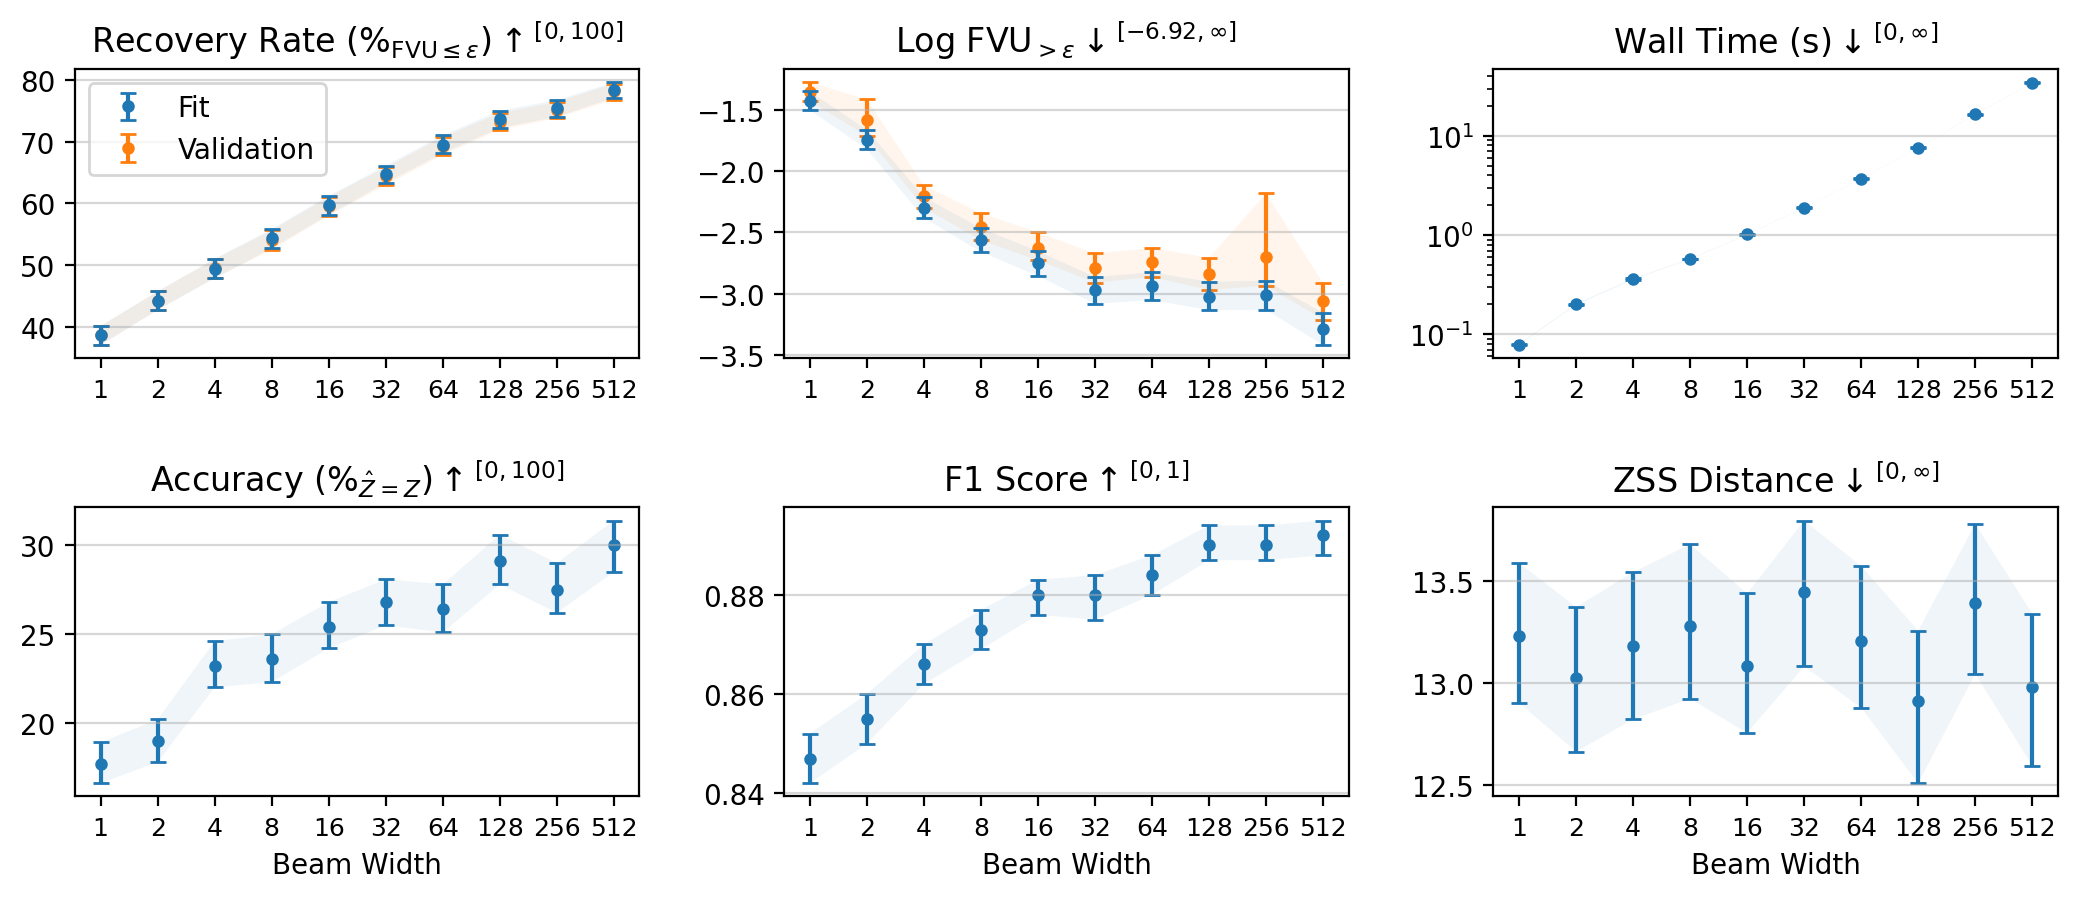

In [48]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['beam_width'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

showed_val_legend = False

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):

    show_metrics = [show_metric]
    if f'{show_metric}_val' in total_summary_tables[sub_metric]['median'].T.index:
        show_metrics.append(f'{show_metric}_val')
    
    for k, (s, label) in enumerate(zip(show_metrics, ['Fit', 'Validation'])):
        y = total_summary_tables[sub_metric]['median'].T.loc[s] * factor
        y_lower = total_summary_tables[sub_metric]['lower'].T.loc[s] * factor
        y_upper = total_summary_tables[sub_metric]['upper'].T.loc[s] * factor

        ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3, zorder=len(show_metrics) - k, label=label)
        sorted_indices = np.argsort(x)
        ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07, zorder=len(show_metrics) - k)

    if not showed_val_legend:
        ax.legend(loc='upper left')
        showed_val_legend = True

    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Beam Width')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y')

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_errorbars.svg'))

In [49]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6569/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:06,  4.18it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:393: RuntimeWarning: All-NaN slice encountered
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_shape_base_impl.py:416: RuntimeWarning: All-NaN slice encountered
  buff[ind] = asanyarray(func1d(

In [50]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [51]:
from matplotlib.colors import LogNorm

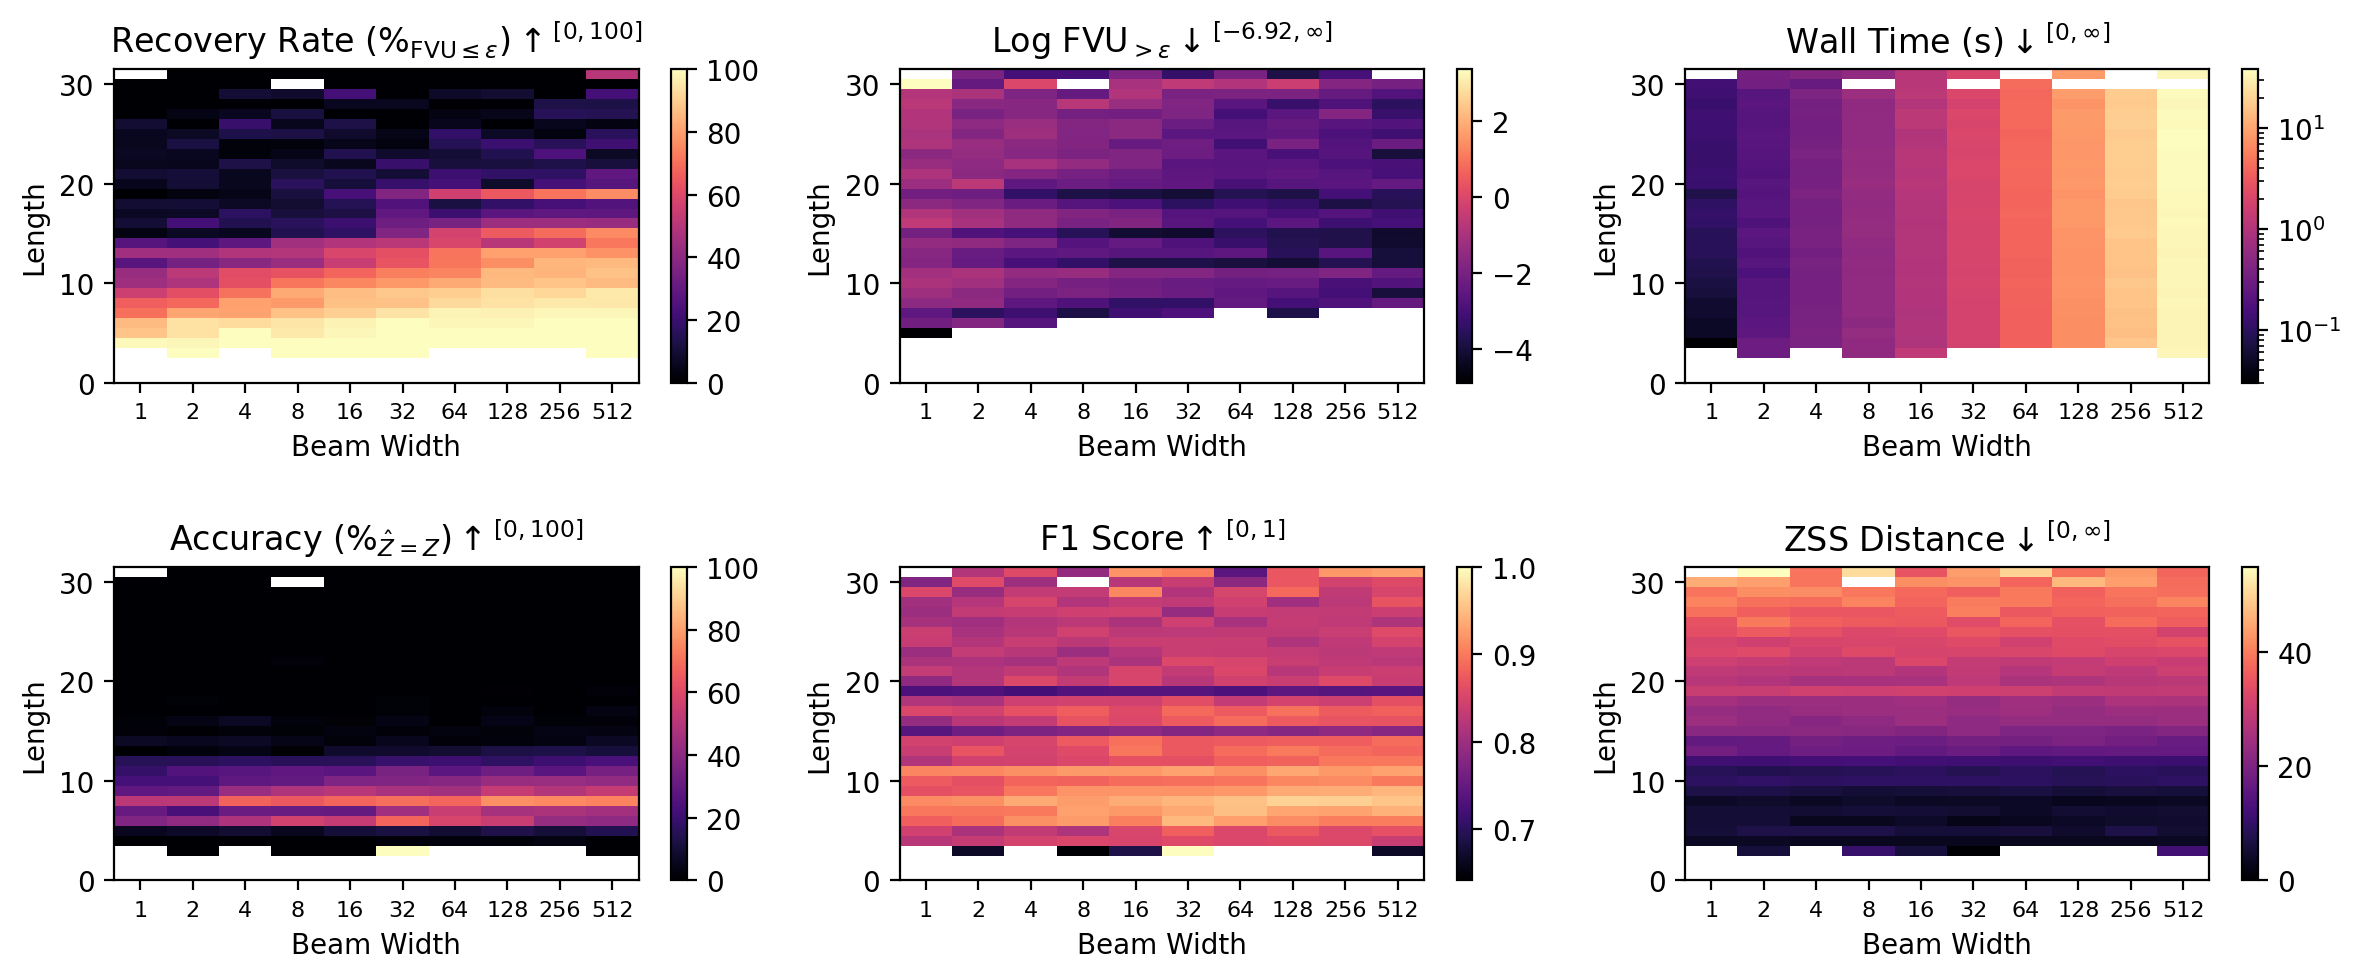

In [52]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
log_norm_list = [False, False, True, False, False, False]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['beam_width'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))